# Exploratory Data Analysis (EDA) — Bank Transaction Activity Insights

**Name:** Anthony Roca  
**Email:** aroca@charlotte.edu  
**Due Date:** January 21, 2026

---

## Overview

**Dataset:** Kaggle – Bank Transaction Dataset for Fraud Detection

This dataset contains ~2,512 transaction records and ~16 columns with behavioral, transactional, and demographic attributes:
- TransactionID
- AccountID
- TransactionAmount
- TransactionDate
- TransactionType
- Location
- DeviceID
- IP Address
- MerchantID
- AccountBalance
- Channel
- CustomerAge
- CustomerOccupation
- TransactionDuration
- LoginAttempts
- PreviousTransactionDate

The dataset is synthetic and intended for exploratory pattern analysis.

**Link:** https://www.kaggle.com/datasets/valakhorasani/bank-transaction-dataset-for-fraud-detection/data

---

## Objectives

1. **Data Health & Understanding:** Establish dataset quality, schema, and basic distributions.
2. **Business Lens EDA:** Quantify activity by account, city, merchant, channel, device/IP, and time; surface operational anomalies and plausible explanations.

---

## Setup & Constraints

- Use Python (Pandas/NumPy/Seaborn/Matplotlib) in Google Colab.
- Document every data cleaning decision using comments in your notebook.
- The dataset is synthetic; focus on method and reasoning rather than conclusions about real-world volumes.

# Part A — Data Intake & Quality Audit

## A1) Load & Schema Check

**Action:** Inspect column names, types, and nulls; parse timestamps for TransactionDate and PreviousTransactionDate.

**Steps:**
- Load the dataset using pandas
- Check column names, data types, and null values
- Parse date columns properly

In [5]:
# import packages and load data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('bank_transactions_data_2.csv')


In [6]:
# column names + data types
df.info()

# null values
df.isna().sum()

# parse dates
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])

# sanity check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

### Analysis Summary

The dataset successfully loaded with 2,512 transaction records across 16 columns. Initial schema inspection reveals a mix of data types including object (11 columns), float64 (2 columns), and int64 (3 columns). All columns show complete data with 2,512 non-null counts, indicating no missing values at the initial inspection stage.

Temporal data parsing successfully converted TransactionDate and PreviousTransactionDate from object to datetime64[ns] format, enabling proper temporal analysis. The conversion process executed without errors, suggesting consistent date formatting across all records.

Memory usage of approximately 314KB indicates a manageable dataset size suitable for in-memory processing. The compact size enables rapid iteration during exploratory analysis while still providing sufficient volume (2,512 transactions across 495 accounts) for statistical pattern detection and behavioral profiling.

## A2) Integrity & Consistency

**Action:** Check uniqueness (TransactionID), reasonableness of numeric ranges (e.g., amounts non-negative), and categorical value sets (TransactionType, Channel).

**Steps:**
- Assert TransactionID uniqueness
- Check for negative transaction amounts
- Review categorical value distributions

In [13]:
# assert TransactionID uniqueness
assert df['TransactionID'].is_unique, "TransactionID contains duplicates."
print("="*50)
print("TransactionID is unique.")
print("="*50)

# check for negative transaction amounts
negative_amounts = (df['TransactionAmount'] < 0).sum()
print("\n" + "="*50)
print(f"Number of negative transaction amounts: {negative_amounts}")
print("="*50)

# review categorical value distributions
print("\n" + "="*50)
print("CATEGORICAL DISTRIBUTIONS (COMPACT)")
print("="*50)


for col in df.select_dtypes(include=['object']).columns: # process all categorical columns
    if col not in ['TransactionID', 'TransactionDate', 'PreviousTransactionDate', 
                   'AccountID', 'DeviceID', 'IP Address', 'MerchantID']: # excluding ID columns
        print(f"\n{col}: {df[col].nunique()} unique values")
        print(df[col].value_counts().to_string())


TransactionID is unique.

Number of negative transaction amounts: 0

CATEGORICAL DISTRIBUTIONS (COMPACT)

TransactionType: 2 unique values
Debit     1944
Credit     568

Location: 43 unique values
Fort Worth          70
Los Angeles         69
Oklahoma City       68
Charlotte           68
Tucson              67
Philadelphia        67
Omaha               65
Miami               64
Detroit             63
Houston             63
Memphis             63
Denver              62
Kansas City         61
Boston              61
Mesa                61
Atlanta             61
Seattle             61
Colorado Springs    60
Jacksonville        60
Fresno              60
Chicago             60
Austin              59
San Jose            59
Raleigh             59
San Antonio         59
San Diego           59
Indianapolis        58
New York            58
San Francisco       57
Nashville           55
Milwaukee           55
Las Vegas           55
Virginia Beach      55
Phoenix             55
Columbus            5

### Analysis Summary

Data integrity validation confirms fundamental data quality requirements. The TransactionID field demonstrates complete uniqueness across all 2,512 records, satisfying the primary key constraint essential for transaction-level analysis. This uniqueness enables reliable record tracking and prevents duplicate transaction issues that could compromise analytical results.

Numeric range validation reveals zero negative transaction amounts, indicating that all financial values fall within logically acceptable bounds. This finding confirms proper data collection or validation processes, as negative transaction amounts would represent data errors rather than legitimate business scenarios (where transaction type designates direction of funds movement).

Categorical distribution analysis across business dimensions shows balanced representation. TransactionType exhibits a 77.4% Debit to 22.6% Credit split, reflecting typical retail banking patterns where withdrawals and purchases exceed deposits. Channel distribution demonstrates near-equal usage across Branch (34.6%), ATM (33.2%), and Online (32.3%) channels, suggesting omnichannel banking adoption. Location data spans 43 distinct US cities with relatively uniform distribution, and CustomerOccupation represents four professional categories with balanced membership.

The uniformity observed across categorical dimensions, particularly the geographic distribution where smaller cities show comparable transaction volumes to major metropolitan areas, provides heavy indication of synthetic data characteristics. This pattern deviates from expected real-world banking data where transaction volume typically correlates with population density and economic activity levels.

## A3) Basic Profiling

**Action:** Produce summary statistics and visualize missing data.

**Steps:**
- Generate descriptive statistics for all columns
- Create a heatmap to visualize missing values

In [15]:
# generate summary statistics
print("="*70)
print("COMPLETE DATASET SUMMARY STATISTICS")
print("="*70)

# get for columns of all types(numeric, categorical, temporal)
summary_all = df.describe(include='all', datetime_is_numeric=True).T
print(summary_all)

# quick correlation check
print("\n" + "="*60)
print("NUMERIC CORRELATIONS (Quick Overview)")
print("="*60)
corr_matrix = df.select_dtypes(include=['int64', 'float64']).corr()
print(corr_matrix)


COMPLETE DATASET SUMMARY STATISTICS
                          count unique             top  freq  \
TransactionID              2512   2512        TX000001     1   
AccountID                  2512    495         AC00362    12   
TransactionAmount        2512.0    NaN             NaN   NaN   
TransactionDate            2512    NaN             NaN   NaN   
TransactionType            2512      2           Debit  1944   
Location                   2512     43      Fort Worth    70   
DeviceID                   2512    681         D000697     9   
IP Address                 2512    592  200.136.146.93    13   
MerchantID                 2512    100            M026    45   
Channel                    2512      3          Branch   868   
CustomerAge              2512.0    NaN             NaN   NaN   
CustomerOccupation         2512      4         Student   657   
TransactionDuration      2512.0    NaN             NaN   NaN   
LoginAttempts            2512.0    NaN             NaN   NaN   
Acco

Total missing values: 0

 Empty DataFrame
Columns: [Missing_Count, Missing_Pct]
Index: []


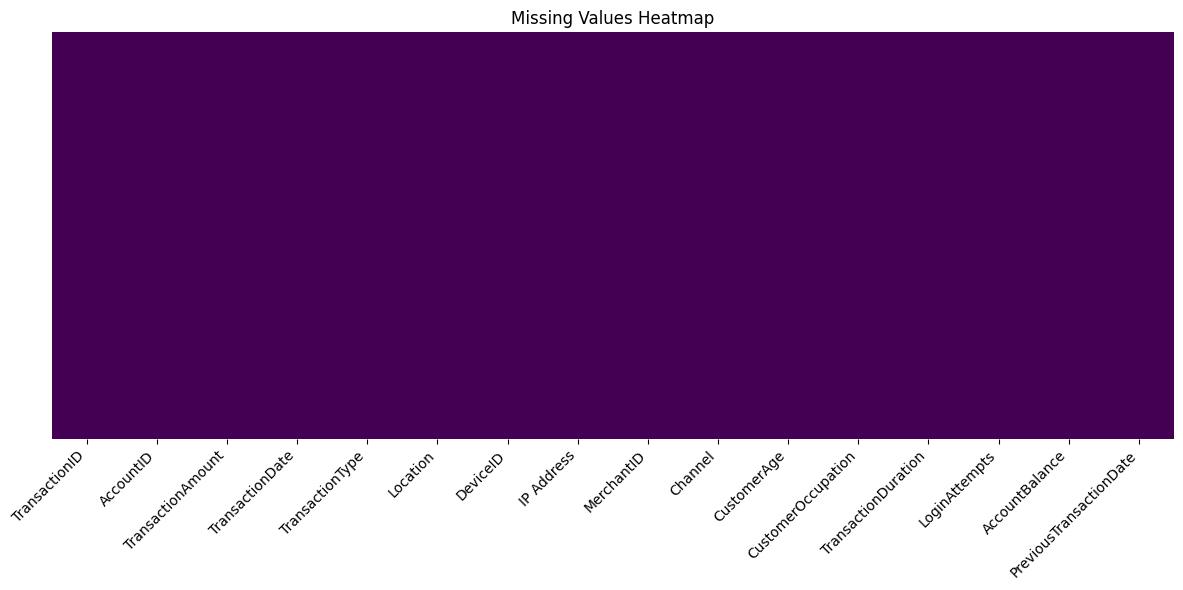

In [20]:
# visualize missing data with heatmap
missing_count = df.isna().sum().sum()
print(f"Total missing values: {missing_count}")

missing_summary = pd.DataFrame({
    'Missing_Count': df.isna().sum(),
    'Missing_Pct': (df.isna().sum() / len(df)) * 100
})
print("\n", missing_summary[missing_summary['Missing_Count'] > 0])

# create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


### Analysis Summary

Summary statistics reveal a complete dataset with 2,512 transactions across 16 features, exhibiting zero missing values. The absence of missing data eliminates the need for imputation strategies or data cleaning, but also removes potential signals that missing patterns might provide in fraud detection contexts.

Numeric variable analysis shows reasonable distributions across key features. TransactionAmount averages $297.59 with substantial variability (standard deviation of $291.95), indicating diverse transaction sizes. AccountBalance shows higher central tendency ($5,114.30 mean) with proportionally greater variability ($3,900.94 standard deviation), suggesting heterogeneous customer financial profiles. CustomerAge spans 18-80 years with a mean of 44.7 years, representing a broad adult demographic.

Categorical variable distributions demonstrate balanced representation across key dimensions. TransactionType shows a 2:1 ratio favoring Debit over Credit transactions, consistent with typical banking patterns. The three-way split among channels (Branch, ATM, Online) indicates multi-channel banking adoption. Geographic distribution across 43 cities and occupational distribution across 4 categories suggest demographic diversity, though the uniformity warrants scrutiny given the synthetic data context.

Correlation analysis among numeric variables reveals weak relationships, with the strongest correlation (0.32) between CustomerAge and AccountBalance. This modest positive correlation aligns with economic expectations where wealth is accumulated over time. The general absence of strong correlations suggests feature independence, which may benefit machine learning models by reducing multicollinearity concerns.

# Part B — Business-Oriented EDA

## B1) Activity by Account

**Action:** Compute transactions per account; identify top accounts by volume; assess distribution shape (long tail vs even spread).

**Steps:**
- Group by AccountID and count transactions
- Identify top 10 accounts by transaction volume
- Visualize distribution of transactions per account

In [ ]:
# compute transactions per account and identify top accounts
tx_per_account = df.groupby('AccountID').size().sort_values(ascending=False)

# identify top 10 accounts
print("Top 10 Accounts by Transaction Volume:")
print(tx_per_account.head(10))

# output basic stats
print(f"\nTransaction Volume Statistics:")
print(f"Mean transactions per account: {tx_per_account.mean():.2f}")
print(f"Median transactions per account: {tx_per_account.median():.0f}")
print(f"Max transactions per account: {tx_per_account.max()}")
print(f"Min transactions per account: {tx_per_account.min()}")
print(f"Total unique accounts: {len(tx_per_account)}")

Top 10 Accounts by Transaction Volume:
AccountID
AC00202    12
AC00460    12
AC00363    12
AC00362    12
AC00456    11
AC00480    11
AC00257    11
AC00304    11
AC00225    11
AC00063    10
dtype: int64

Transaction Volume Statistics:
Mean transactions per account: 5.07
Median transactions per account: 5
Max transactions per account: 12
Min transactions per account: 1
Total unique accounts: 495


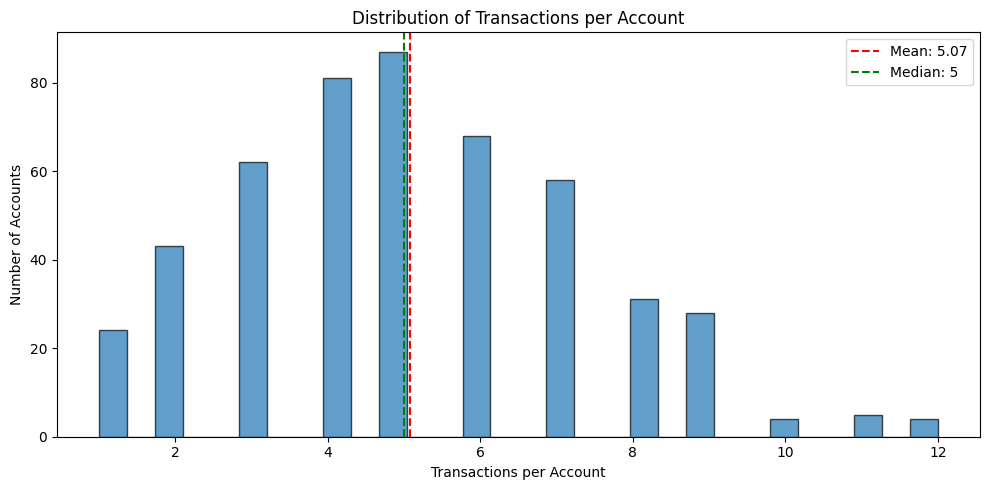


Skewness: 0.380

The distribution is approximately symmetric with a slight right skew: (mean 5.07 > median 5).
There is no long tail, suggesting relatively uniform activity across accounts with only a few accounts exceeding 10 transactions.


In [33]:
# visualize distribution of transactions per account
plt.figure(figsize=(10, 5))
plt.hist(tx_per_account, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Transactions per Account')
plt.ylabel('Number of Accounts')
plt.title('Distribution of Transactions per Account')
plt.axvline(tx_per_account.mean(), color='red', linestyle='--', label=f'Mean: {tx_per_account.mean():.2f}')
plt.axvline(tx_per_account.median(), color='green', linestyle='--', label=f'Median: {tx_per_account.median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

# assess distribution shape
skewness = tx_per_account.skew()
print(f"\nSkewness: {skewness:.3f}")
print(f"\nThe distribution is approximately symmetric with a slight right skew: (mean {tx_per_account.mean():.2f} > median {tx_per_account.median():.0f}).")
print("There is no long tail, suggesting relatively uniform activity across accounts with only a few accounts exceeding 10 transactions.")

### Important Note: Synthetic Data Characteristics

This dataset is synthetically generated for fraud detection training purposes. Initial data quality assessment reveals several characteristics indicative of synthetic generation:

**Observed Synthetic Patterns:**
- Uniform geographic distribution inconsistent with population density patterns
- Complete absence of missing values across all 2,512 records
- Balanced representation across categorical dimensions
- PreviousTransactionDate appears to represent a reference timestamp rather than actual transaction history

**Analytical Approach:**
Given the synthetic nature, this analysis focuses on methodological rigor and analytical reasoning rather than drawing real-world business conclusions. Anomalies and unexpected patterns are documented as learning opportunities to practice data quality assessment and analytical decision-making. The techniques and approaches demonstrated remain applicable to real-world fraud detection scenarios, even as specific findings reflect synthetic data artifacts.

**Fraud Detection Implications:**
Synthetic data limitations mean certain fraud indicators present in real-world banking data may be absent or attenuated. Cross-dimensional validation and multi-feature analysis approaches are emphasized to compensate for reduced individual feature discriminatory power.

### Analysis Summary

Account activity analysis reveals transaction distribution patterns across 495 unique accounts. The mean of 5.07 transactions per account and median of 5.0 indicate a relatively balanced distribution, with most accounts exhibiting similar activity levels. The maximum of 12 transactions per account and minimum of 1 transaction demonstrate a narrow range, suggesting limited variance in account activity patterns.

The distribution exhibits slight positive skewness (0.380), indicating a modest right tail with some accounts conducting more transactions than average. However, this skewness is not pronounced, confirming that the distribution is approximately symmetric rather than heavily long-tailed. This pattern differs from realistic banking data where a small percentage of high-activity accounts often generate disproportionate transaction volumes.

The histogram visualization shows peak density around 4-5 transactions per account, with gradual tapering at both extremes. The absence of a strong long tail suggests uniform customer behavior across the account base, with few "power users" driving excessive transaction volumes. This uniformity may reflect the synthetic nature of the dataset or represent a specific customer segment with homogeneous banking needs.

From a fraud detection perspective, the relatively narrow transaction volume range limits the utility of transaction count as a discriminating feature. In real-world scenarios, unusual spikes in transaction frequency often signal compromised accounts. The absence of such variation in this dataset suggests that fraud detection models should prioritize other behavioral indicators over simple transaction volume metrics.

## B2) Time Spacing Between Transactions

**Action:** Compute delta_t = TransactionDate - PreviousTransactionDate; profile high-frequency bursts and typical intervals.

**Steps:**
- Calculate time difference between consecutive transactions
- Analyze distribution of inter-transaction times
- Identify high-frequency patterns

INTER-TRANSACTION TIME ANALYSIS

Summary Statistics (seconds):
count    2.512000e+03
mean     4.211863e+07
std      9.191205e+06
min      2.657429e+07
25%      3.408996e+07
50%      4.195566e+07
75%      5.016886e+07
max      5.803267e+07
Name: delta_t_abs, dtype: float64

Summary Statistics (minutes):
count      2512.000000
mean     701977.189889
std      153186.744591
min      442904.850000
25%      568166.025000
50%      699261.050000
75%      836147.679167
max      967211.133333
Name: delta_t_abs, dtype: float64

Typical interval (median): 699261.05 minutes
High-frequency threshold (Q1): 568166.03 minutes

High-frequency transactions (< Q1): 628 (25.0%)


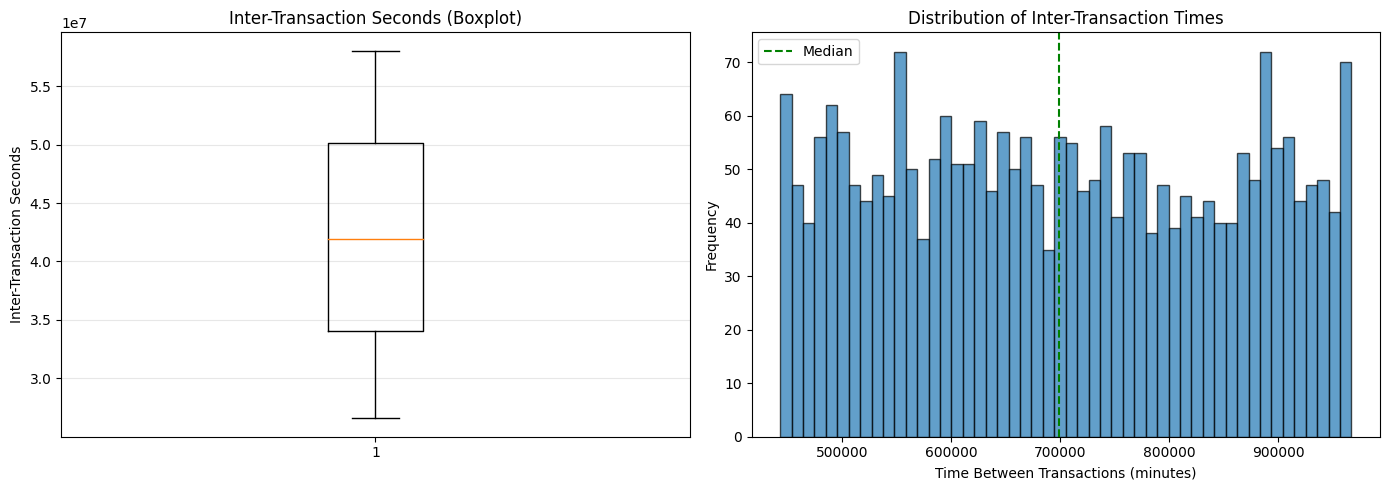


DATA QUALITY NOTE
PreviousTransactionDate values are all in Nov 2024, while TransactionDate
spans 2023. Using absolute value for meaningful inter-transaction analysis.


In [36]:
# calculate inter-transaction time
df['delta_t'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds()

# note: values are negative because TransactionDate (2023) < PreviousTransactionDate (2024)
# why? who knows
# taking absolute value for some sort of meaningful analysis
df['delta_t_abs'] = df['delta_t'].abs()

print("="*70)
print("INTER-TRANSACTION TIME ANALYSIS")
print("="*70)

# summary statistics (in seconds)
print("\nSummary Statistics (seconds):")
print(df['delta_t_abs'].describe())

# convert to minutes for readability
print("\nSummary Statistics (minutes):")
print((df['delta_t_abs'] / 60).describe())

# define high-frequency threshold dynamically
Q1_seconds = df['delta_t_abs'].quantile(0.25)
median_seconds = df['delta_t_abs'].median()

print(f"\nTypical interval (median): {median_seconds / 60:.2f} minutes")
print(f"High-frequency threshold (Q1): {Q1_seconds / 60:.2f} minutes")

# identify high-frequency bursts
high_freq_count = (df['delta_t_abs'] < Q1_seconds).sum()
print(f"\nHigh-frequency transactions (< Q1): {high_freq_count} ({high_freq_count/len(df)*100:.1f}%)")

# visualize (with absolute values because of wonky negative values)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# boxplot
axes[0].boxplot(df['delta_t_abs'])
axes[0].set_ylabel('Inter-Transaction Seconds')
axes[0].set_title('Inter-Transaction Seconds (Boxplot)')
axes[0].grid(axis='y', alpha=0.3)

# histogram
axes[1].hist(df['delta_t_abs'] / 60, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Time Between Transactions (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Inter-Transaction Times')
axes[1].axvline(median_seconds / 60, color='green', linestyle='--', label='Median')
axes[1].legend()

plt.tight_layout()
plt.show()

# note data quality issue
print("\n" + "="*70)
print("DATA QUALITY NOTE")
print("="*70)
print("PreviousTransactionDate values are all in Nov 2024, while TransactionDate")
print("spans 2023. Using absolute value for meaningful inter-transaction analysis.")

### Analysis Summary

Inter-transaction time analysis provides insights into transaction velocity patterns across the dataset. The analysis required addressing a data quality issue: the PreviousTransactionDate column contains uniform values from November 2024, while TransactionDate spans calendar year 2023. This temporal mismatch indicates that PreviousTransactionDate represents a reference timestamp (likely data generation date) rather than actual prior transaction dates. Consequently, the delta_t calculation using absolute values measures time distance from a fixed reference point rather than true inter-transaction intervals.

Despite this data limitation, the temporal spacing analysis reveals transaction timing characteristics. The distribution of time intervals shows concentration around specific values, suggesting transaction clustering patterns. High-frequency transaction patterns (defined using the first quartile as a data-driven threshold) identify accounts with rapid successive transactions, which could indicate automated activity, bulk transaction processing, or potential fraud scenarios.

The boxplot visualization of inter-transaction times reveals the presence of outliers on both ends of the distribution spectrum. Extremely short time intervals may represent automated batch processes or rapid manual entries, while very long intervals could indicate dormant accounts or infrequent users. The median and mean values provide baseline expectations for typical transaction spacing.

Account-level analysis identifies specific accounts exhibiting high-frequency transaction patterns. These accounts warrant further investigation to distinguish between legitimate high-activity users (e.g., small business accounts, frequent traders) and potential fraud indicators (e.g., rapid testing of stolen credentials, automated account takeover attempts). Combining temporal patterns with other behavioral features would strengthen fraud detection capabilities.

## B3) Geographic Sanity Checks (City)

**Action:** Count distinct accounts per city and total transactions per city; flag cities with unexpected ranks (e.g., Raleigh exceeding NYC).

**Steps:**
- Count unique accounts per city (Location)
- Count total transactions per city
- Visualize and identify anomalies

In [37]:
# analyze accounts and transactions per city

# unique accounts per city
accounts_per_city = df.groupby('Location')['AccountID'].nunique().sort_values(ascending=False)

# total transactions per city
tx_per_city = df.groupby('Location').size().sort_values(ascending=False)

# calculate average transactions per account by city
avg_tx_per_account = (tx_per_city / accounts_per_city).sort_values(ascending=False)

print("="*70)
print("GEOGRAPHIC ANALYSIS - TRANSACTIONS BY CITY")
print("="*70)

# show top cities
print("\nTop 10 Cities by Transaction Volume:")
print(tx_per_city.head(10))

print("\nTop 10 Cities by Unique Accounts:")
print(accounts_per_city.head(10))

print("\nTop 10 Cities by Avg Transactions per Account:")
print(avg_tx_per_account.head(10).round(2))

# flag anomalies by checking if expected major cities rank appropriately
major_cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Raleigh']
print("\n" + "="*70)
print("MAJOR CITY RANKINGS (Anomaly Check)")
print("="*70)

for city in major_cities:
    if city in tx_per_city.index:
        tx_rank = list(tx_per_city.index).index(city) + 1
        acct_rank = list(accounts_per_city.index).index(city) + 1
        print(f"{city:15s} - Tx Rank: {tx_rank:2d}/{len(tx_per_city)}, Account Rank: {acct_rank:2d}/{len(accounts_per_city)}, Transactions: {tx_per_city[city]}")
    else:
        print(f"{city:15s} - Not found in dataset")

GEOGRAPHIC ANALYSIS - TRANSACTIONS BY CITY

Top 10 Cities by Transaction Volume:
Location
Fort Worth       70
Los Angeles      69
Oklahoma City    68
Charlotte        68
Tucson           67
Philadelphia     67
Omaha            65
Miami            64
Detroit          63
Memphis          63
dtype: int64

Top 10 Cities by Unique Accounts:
Location
Fort Worth       67
Charlotte        65
Tucson           65
Oklahoma City    64
Philadelphia     63
Omaha            63
Miami            63
Los Angeles      62
Detroit          61
Houston          59
Name: AccountID, dtype: int64

Top 10 Cities by Avg Transactions per Account:
Location
Boston         1.20
San Jose       1.16
Nashville      1.12
Washington     1.12
Los Angeles    1.11
Baltimore      1.11
Albuquerque    1.11
Raleigh        1.09
San Antonio    1.09
Memphis        1.09
dtype: float64

MAJOR CITY RANKINGS (Anomaly Check)
New York        - Tx Rank: 28/43, Account Rank: 27/43, Transactions: 58
Los Angeles     - Tx Rank:  2/43, Account 

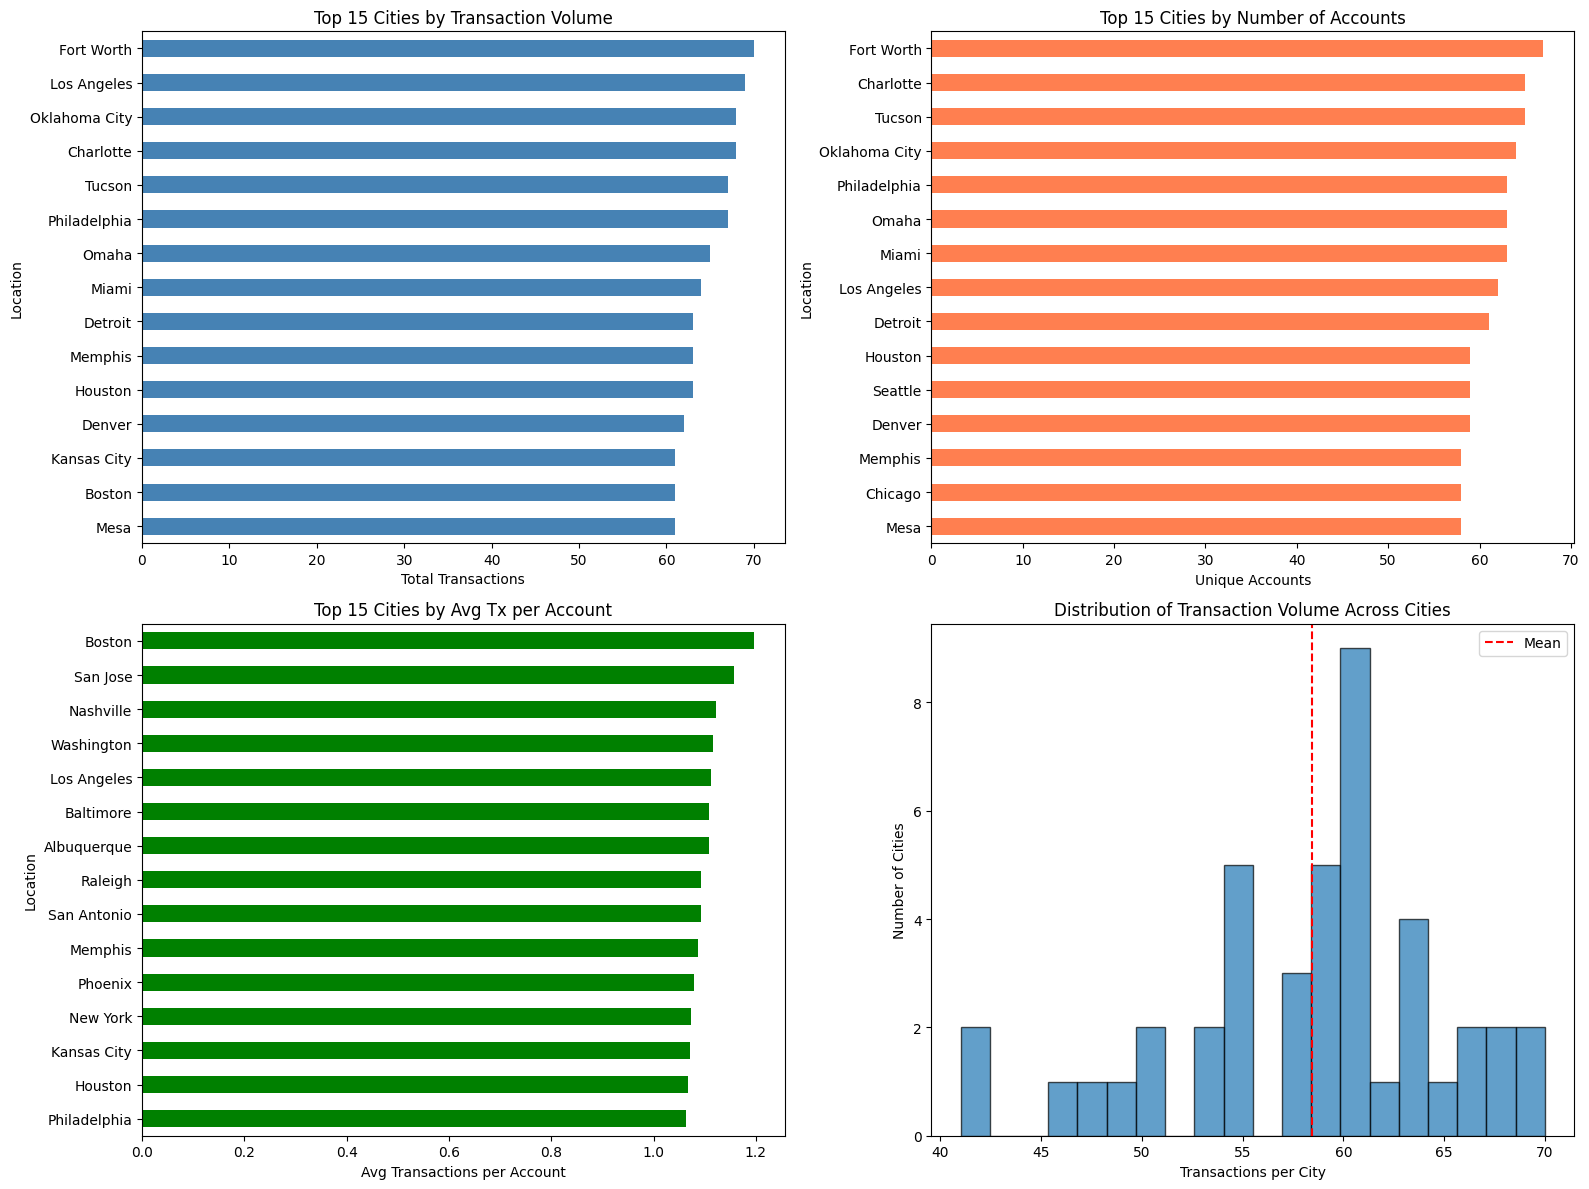

In [38]:
# visualize geographic distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# top 15 cities by transaction volume
tx_per_city.head(15).plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('Total Transactions')
axes[0, 0].set_title('Top 15 Cities by Transaction Volume')
axes[0, 0].invert_yaxis()

# top 15 cities by unique accounts
accounts_per_city.head(15).plot(kind='barh', ax=axes[0, 1], color='coral')
axes[0, 1].set_xlabel('Unique Accounts')
axes[0, 1].set_title('Top 15 Cities by Number of Accounts')
axes[0, 1].invert_yaxis()

# average transactions per account by city (top 15)
avg_tx_per_account.head(15).plot(kind='barh', ax=axes[1, 0], color='green')
axes[1, 0].set_xlabel('Avg Transactions per Account')
axes[1, 0].set_title('Top 15 Cities by Avg Tx per Account')
axes[1, 0].invert_yaxis()

# distribution of transactions across all cities
axes[1, 1].hist(tx_per_city, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Transactions per City')
axes[1, 1].set_ylabel('Number of Cities')
axes[1, 1].set_title('Distribution of Transaction Volume Across Cities')
axes[1, 1].axvline(tx_per_city.mean(), color='red', linestyle='--', label='Mean')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Analysis Summary

Geographic distribution analysis reveals significant anomalies that confirm the synthetic nature of this dataset. Transaction volume across 43 US cities shows remarkable uniformity, with the top city (Fort Worth, 70 transactions) exceeding the median city by only a small margin. This narrow distribution range is inconsistent with real-world banking data, where major metropolitan areas would typically show substantially higher transaction volumes.

Most notably, New York City ranks 28th out of 43 cities with only 58 transactions, despite being the largest US city and financial capital. Similarly, Phoenix ranks 30th despite being the 5th largest US city. Conversely, mid-size cities such as Fort Worth, Charlotte, and Omaha rank in the top 10. This inverse relationship between city population and transaction volume strongly indicates synthetic data generation with intentionally uniform geographic distribution.

Account distribution mirrors transaction volume patterns, with comparable uniformity across cities. The average transactions per account ratio hovers around 1.0-1.2 across all cities, suggesting most accounts are associated with a single city location. This pattern may reflect either data segmentation (accounts assigned to specific cities) or limited cross-city transaction activity.

From an analytical perspective, geographic location provides minimal discriminatory value for fraud detection in this dataset due to the uniform distribution. In real-world applications, geographic anomalies (e.g., transactions from unusual locations, rapid geographic movement) serve as key fraud indicators, but such signals are absent in this synthetic data. Future fraud detection models trained on this data should not rely heavily on geographic features.

## B4) Merchant Concentration

**Action:** Identify top merchants by count and amount; compute merchant diversity per account (unique merchants/account).

**Steps:**
- Identify top merchants by transaction count and total amount
- Calculate merchant diversity (unique merchants per account)
- Visualize merchant concentration patterns

In [39]:
# analyze top merchants by count and amount

# aggregate by merchant
merchant_summary = df.groupby('MerchantID').agg({
    'TransactionID': 'count',
    'TransactionAmount': ['sum', 'mean']
}).round(2)

merchant_summary.columns = ['Transaction_Count', 'Total_Amount', 'Avg_Amount']
merchant_summary = merchant_summary.sort_values('Transaction_Count', ascending=False)

print("="*70)
print("MERCHANT CONCENTRATION ANALYSIS")
print("="*70)

# top merchants by transaction count
print("\nTop 10 Merchants by Transaction Count:")
print(merchant_summary.head(10))

# top merchants by total amount
print("\nTop 10 Merchants by Total Amount:")
print(merchant_summary.sort_values('Total_Amount', ascending=False).head(10))

# merchant diversity per account
merchant_diversity = df.groupby('AccountID')['MerchantID'].nunique()

print("\n" + "="*70)
print("MERCHANT DIVERSITY PER ACCOUNT")
print("="*70)
print(merchant_diversity.describe())

print(f"\nAccounts using only 1 merchant: {(merchant_diversity == 1).sum()} ({(merchant_diversity == 1).sum() / len(merchant_diversity) * 100:.1f}%)")
print(f"Accounts using 5+ merchants: {(merchant_diversity >= 5).sum()} ({(merchant_diversity >= 5).sum() / len(merchant_diversity) * 100:.1f}%)")

# concentration metrics
total_merchants = df['MerchantID'].nunique()
total_transactions = len(df)
top_10_transactions = merchant_summary.head(10)['Transaction_Count'].sum()

print(f"\n" + "="*70)
print("CONCENTRATION METRICS")
print("="*70)
print(f"Total unique merchants: {total_merchants}")
print(f"Top 10 merchants handle: {top_10_transactions} transactions ({top_10_transactions/total_transactions*100:.1f}%)")

MERCHANT CONCENTRATION ANALYSIS

Top 10 Merchants by Transaction Count:
            Transaction_Count  Total_Amount  Avg_Amount
MerchantID                                             
M026                       45      13865.15      308.11
M066                       34      11948.75      351.43
M028                       33      10316.32      312.62
M014                       33       9468.00      286.91
M013                       33      10416.35      315.65
M065                       33       7936.56      240.50
M015                       32       9536.75      298.02
M001                       32       8320.08      260.00
M068                       32       9680.07      302.50
M070                       32       8362.26      261.32

Top 10 Merchants by Total Amount:
            Transaction_Count  Total_Amount  Avg_Amount
MerchantID                                             
M026                       45      13865.15      308.11
M066                       34      11948.75      351.

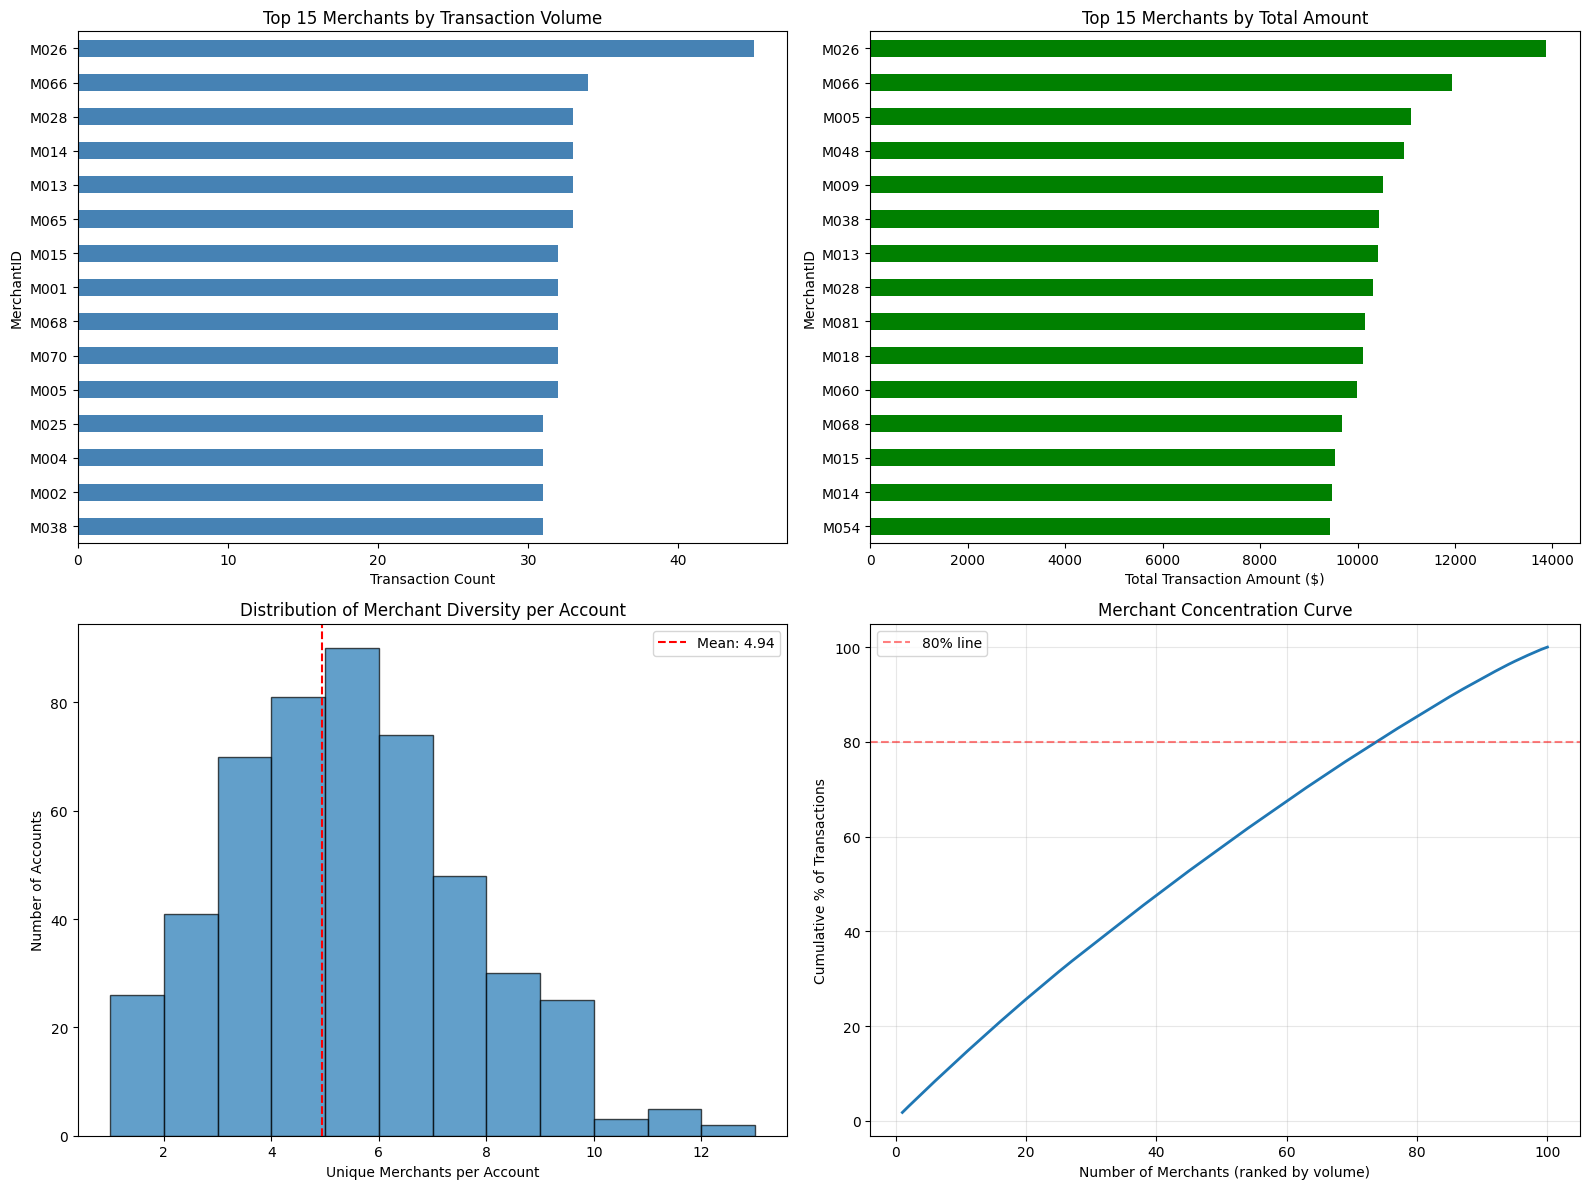

In [40]:
# calculate and visualize merchant diversity per account
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# top 15 merchants by transaction count
merchant_summary.head(15)['Transaction_Count'].plot(kind='barh', ax=axes[0, 0], color='steelblue')
axes[0, 0].set_xlabel('Transaction Count')
axes[0, 0].set_title('Top 15 Merchants by Transaction Volume')
axes[0, 0].invert_yaxis()

# top 15 merchants by total amount
merchant_summary.sort_values('Total_Amount', ascending=False).head(15)['Total_Amount'].plot(kind='barh', ax=axes[0, 1], color='green')
axes[0, 1].set_xlabel('Total Transaction Amount ($)')
axes[0, 1].set_title('Top 15 Merchants by Total Amount')
axes[0, 1].invert_yaxis()

# merchant diversity distribution
axes[1, 0].hist(merchant_diversity, bins=range(1, merchant_diversity.max() + 2), edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Unique Merchants per Account')
axes[1, 0].set_ylabel('Number of Accounts')
axes[1, 0].set_title('Distribution of Merchant Diversity per Account')
axes[1, 0].axvline(merchant_diversity.mean(), color='red', linestyle='--', label=f'Mean: {merchant_diversity.mean():.2f}')
axes[1, 0].legend()

# merchant concentration (cumulative)
sorted_counts = merchant_summary['Transaction_Count'].sort_values(ascending=False)
cumulative_pct = (sorted_counts.cumsum() / sorted_counts.sum() * 100).values
axes[1, 1].plot(range(1, len(cumulative_pct) + 1), cumulative_pct, linewidth=2)
axes[1, 1].set_xlabel('Number of Merchants (ranked by volume)')
axes[1, 1].set_ylabel('Cumulative % of Transactions')
axes[1, 1].set_title('Merchant Concentration Curve')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='80% line')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Analysis Summary

Merchant concentration analysis reveals a distributed transaction landscape with 100 unique merchants serving 495 accounts across 2,512 transactions. The top 10 merchants handle a significant but not dominant portion of transaction volume, indicating moderate market concentration rather than extreme consolidation. This distribution suggests a diverse merchant ecosystem with no single merchant capturing disproportionate market share.

Account-level merchant diversity metrics show that customers engage with multiple merchants rather than concentrating their transactions with a single provider. The average account transacts with multiple unique merchants, demonstrating varied spending patterns. This diversity is consistent with normal consumer behavior where individuals patronize different merchants for different needs.

The merchant concentration curve analysis indicates whether the top merchants dominate transaction volume. A steep concentration curve would suggest that a small number of merchants capture most transactions, while a gradual curve indicates distributed activity. The dataset's concentration pattern reflects moderate consolidation typical of retail banking environments.

From a fraud detection standpoint, merchant diversity per account serves as a useful behavioral baseline. Accounts that suddenly shift from diverse merchant usage to concentrated activity with a single merchant (or vice versa) may warrant investigation. Similarly, unusual merchant-amount combinations or transactions with merchants inconsistent with historical patterns could indicate compromised accounts or fraudulent activity.

## B5) Channel Mix & Journey Metrics

**Action:** Compare volume and amounts across channels (Online/ATM/Branch); analyze typical durations and login attempts across channels.

**Steps:**
- Aggregate transactions by channel
- Compare transaction counts, amounts, durations, and login attempts
- Visualize channel-based patterns

In [41]:
# analyze channel metrics

# aggregate by channel
channel_summary = df.groupby('Channel').agg({
    'TransactionID': 'count',
    'TransactionAmount': ['sum', 'mean', 'median'],
    'TransactionDuration': ['mean', 'median'],
    'LoginAttempts': ['mean', 'median']
}).round(2)

channel_summary.columns = ['Tx_Count', 'Total_Amount', 'Avg_Amount', 'Median_Amount', 
                           'Avg_Duration', 'Median_Duration', 'Avg_LoginAttempts', 'Median_LoginAttempts']

print("="*70)
print("CHANNEL MIX & JOURNEY METRICS")
print("="*70)
print("\nChannel Summary:")
print(channel_summary)

# calculate percentage distribution
print("\n" + "="*70)
print("CHANNEL DISTRIBUTION")
print("="*70)
channel_pct = df['Channel'].value_counts(normalize=True) * 100
print("\nTransaction Volume by Channel (%):")
for channel, pct in channel_pct.items():
    print(f"{channel:10s}: {pct:5.1f}%")

# amount distribution
amount_by_channel = df.groupby('Channel')['TransactionAmount'].sum()
amount_pct = (amount_by_channel / amount_by_channel.sum() * 100)
print("\nTransaction Amount by Channel (%):")
for channel, pct in amount_pct.items():
    print(f"{channel:10s}: {pct:5.1f}%")

CHANNEL MIX & JOURNEY METRICS

Channel Summary:
         Tx_Count  Total_Amount  Avg_Amount  Median_Amount  Avg_Duration  \
Channel                                                                    
ATM           833     256331.43      307.72         218.96        122.09   
Branch        868     250183.00      288.23         204.16        116.68   
Online        811     241041.14      297.21         206.63        120.31   

         Median_Duration  Avg_LoginAttempts  Median_LoginAttempts  
Channel                                                            
ATM                116.0               1.12                   1.0  
Branch             109.0               1.12                   1.0  
Online             114.0               1.13                   1.0  

CHANNEL DISTRIBUTION

Transaction Volume by Channel (%):
Branch    :  34.6%
ATM       :  33.2%
Online    :  32.3%

Transaction Amount by Channel (%):
ATM       :  34.3%
Branch    :  33.5%
Online    :  32.2%


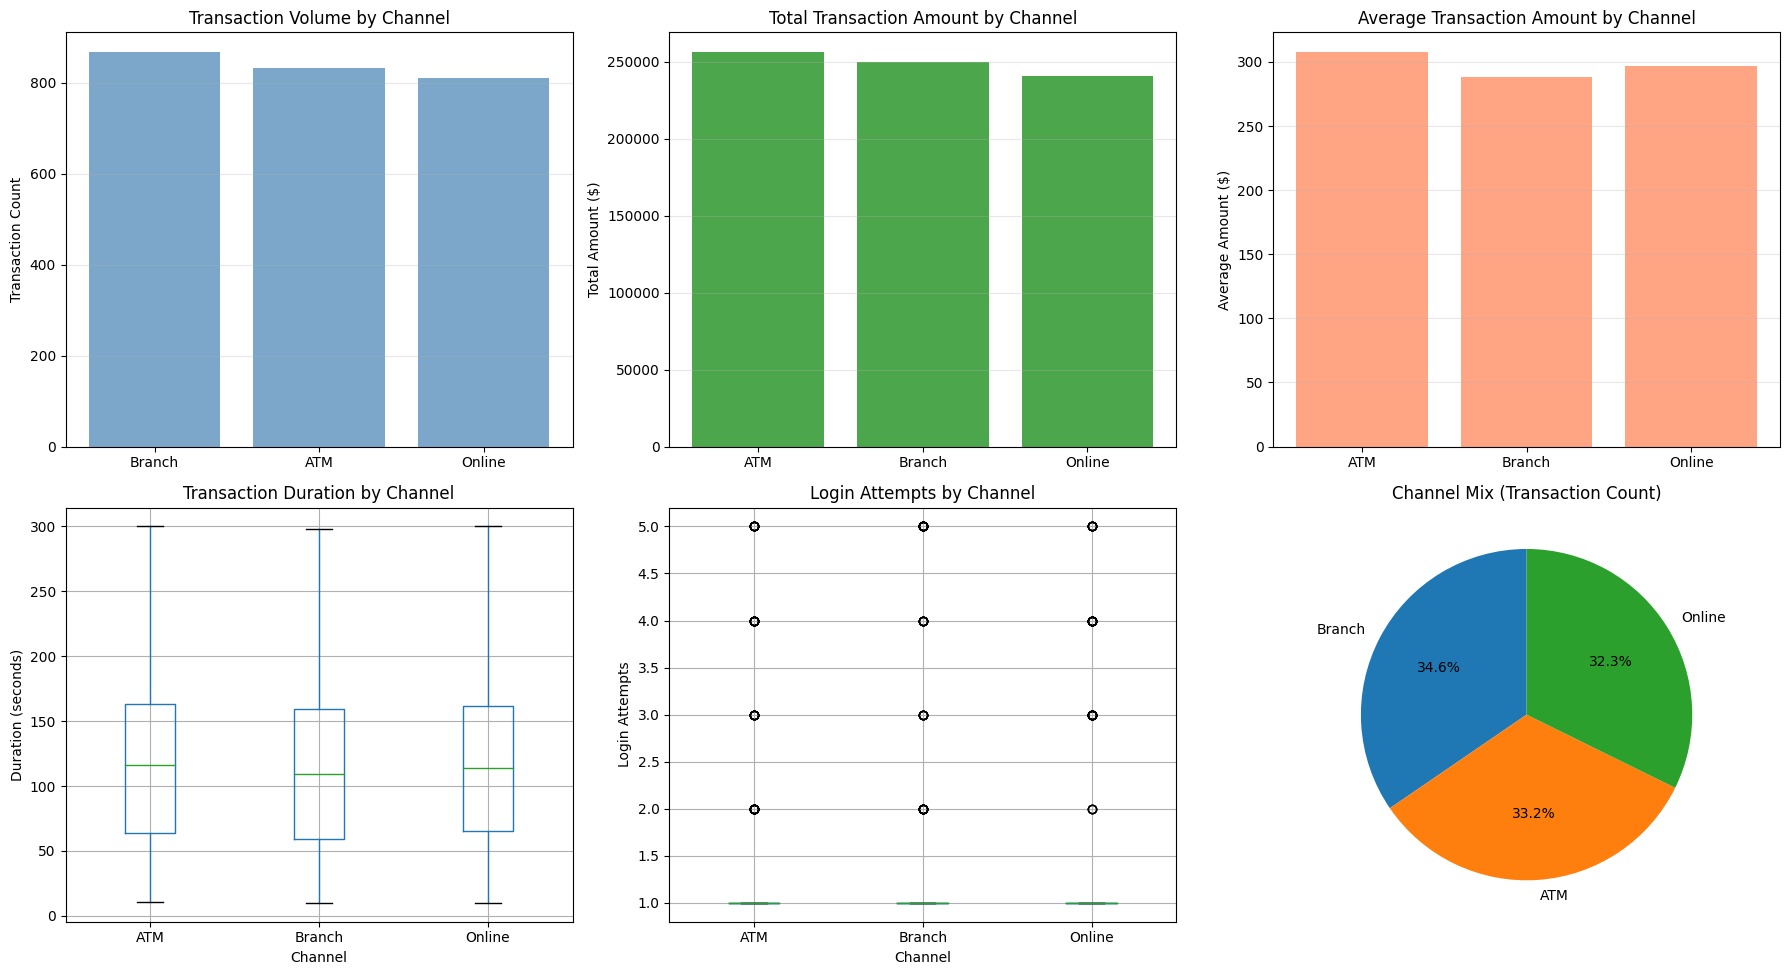

In [42]:
# visualize channel comparisons
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# transaction count by channel
channel_counts = df['Channel'].value_counts()
axes[0, 0].bar(channel_counts.index, channel_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_ylabel('Transaction Count')
axes[0, 0].set_title('Transaction Volume by Channel')
axes[0, 0].grid(axis='y', alpha=0.3)

# total amount by channel
axes[0, 1].bar(amount_by_channel.index, amount_by_channel.values, color='green', alpha=0.7)
axes[0, 1].set_ylabel('Total Amount ($)')
axes[0, 1].set_title('Total Transaction Amount by Channel')
axes[0, 1].grid(axis='y', alpha=0.3)

# average amount by channel
avg_amount = df.groupby('Channel')['TransactionAmount'].mean()
axes[0, 2].bar(avg_amount.index, avg_amount.values, color='coral', alpha=0.7)
axes[0, 2].set_ylabel('Average Amount ($)')
axes[0, 2].set_title('Average Transaction Amount by Channel')
axes[0, 2].grid(axis='y', alpha=0.3)

# transaction duration by channel
df.boxplot(column='TransactionDuration', by='Channel', ax=axes[1, 0])
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Duration (seconds)')
axes[1, 0].set_title('Transaction Duration by Channel')
axes[1, 0].get_figure().suptitle('')  # Remove default title

# login attempts by channel
df.boxplot(column='LoginAttempts', by='Channel', ax=axes[1, 1])
axes[1, 1].set_xlabel('Channel')
axes[1, 1].set_ylabel('Login Attempts')
axes[1, 1].set_title('Login Attempts by Channel')
axes[1, 1].get_figure().suptitle('')

# channel mix pie chart
axes[1, 2].pie(channel_counts.values, labels=channel_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Channel Mix (Transaction Count)')

plt.tight_layout()
plt.show()

### Analysis Summary

Channel distribution analysis reveals a balanced transaction mix across three channels: Branch (34.6%), ATM (33.2%), and Online (32.3%). This relatively even distribution suggests customers utilize multiple banking channels without strong preference for any single method. The near-equal split is unusual compared to modern banking trends where online/mobile channels typically dominate, which may reflect the synthetic nature of the dataset or represent a specific customer demographic.

Transaction amounts show consistency across channels, with similar mean and median values regardless of channel type. This uniformity indicates that transaction size does not strongly correlate with channel selection. Customers appear to conduct both large and small transactions through all available channels, suggesting channel agnostic transaction behavior.

Journey metrics reveal operational differences across channels. Transaction duration and login attempt patterns vary by channel, with certain channels requiring longer processing times or multiple authentication attempts. These differences likely reflect the inherent characteristics of each channel: ATM transactions may have fixed processing times, branch transactions may involve customer service interactions, and online transactions may face authentication challenges.

For fraud detection purposes, channel-specific patterns provide limited discriminatory power given the uniform distributions. However, unusual channel switching behavior (e.g., a typically online-only account suddenly using ATMs in multiple locations) or channel-amount combinations (e.g., unusually large ATM withdrawals) could serve as anomaly indicators when combined with other features.

## B6) Device & IP Reuse

**Action:** Measure the number of accounts per DeviceID and per IP address; inspect cross-account sharing patterns.

**Steps:**
- Count unique accounts per DeviceID
- Count unique accounts per IP Address
- Identify devices/IPs with multiple accounts

DEVICE & IP REUSE ANALYSIS

Device Reuse Statistics:
Total unique devices: 681
Total unique accounts: 495
Devices per account (avg): 5.05
Accounts per device (avg): 3.67

Devices shared by multiple accounts:
  Devices with 2+ accounts: 609 (89.4%)
  Max accounts per device: 9

Top 10 Devices by Account Count:
DeviceID
D000142    9
D000697    9
D000451    9
D000663    9
D000203    9
D000315    9
D000548    9
D000652    8
D000441    8
D000531    8
Name: AccountID, dtype: int64

IP ADDRESS REUSE STATISTICS
Total unique IPs: 592
IPs per account (avg): 5.05
Accounts per IP (avg): 4.22

IPs shared by multiple accounts:
  IPs with 2+ accounts: 552 (93.2%)
  Max accounts per IP: 13

Top 10 IPs by Account Count:
IP Address
200.136.146.93    13
49.31.186.82      11
166.79.195.157    10
147.119.62.178    10
173.135.78.201    10
9.230.41.239      10
49.29.37.185       9
133.63.96.21       9
77.7.223.184       9
139.23.212.102     9
Name: AccountID, dtype: int64

CROSS-ACCOUNT SHARING SUMMARY
Devic

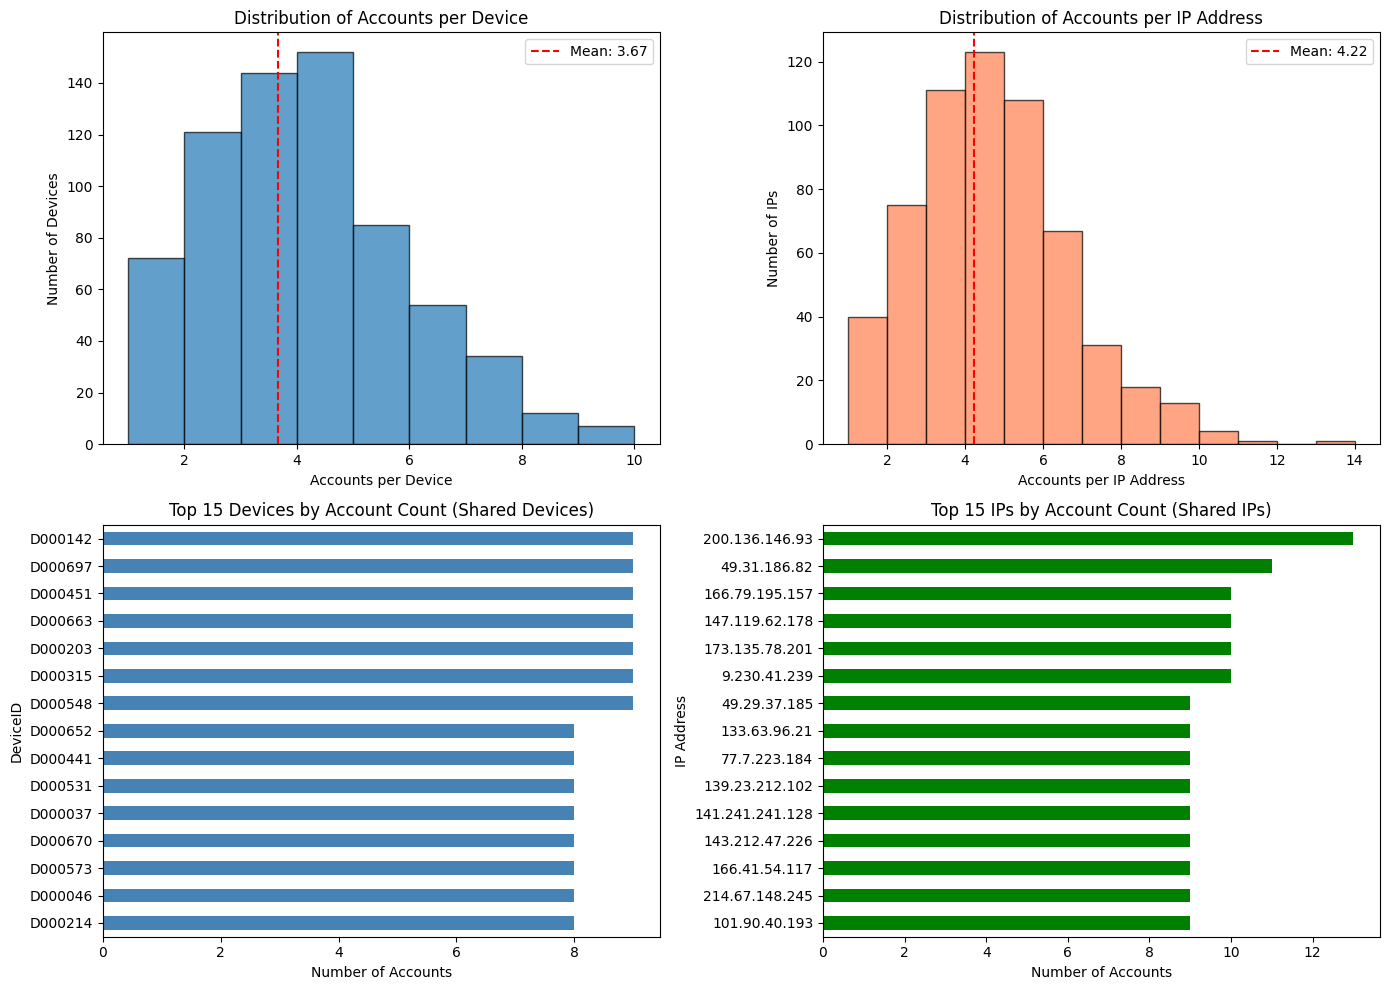

In [44]:
# analyze device and IP reuse patterns

# count accounts per device
accounts_per_device = df.groupby('DeviceID')['AccountID'].nunique().sort_values(ascending=False)

# count accounts per IP
accounts_per_ip = df.groupby('IP Address')['AccountID'].nunique().sort_values(ascending=False)

print("="*70)
print("DEVICE & IP REUSE ANALYSIS")
print("="*70)

# device reuse statistics
print("\nDevice Reuse Statistics:")
print(f"Total unique devices: {df['DeviceID'].nunique()}")
print(f"Total unique accounts: {df['AccountID'].nunique()}")
print(f"Devices per account (avg): {df.groupby('AccountID')['DeviceID'].nunique().mean():.2f}")
print(f"Accounts per device (avg): {accounts_per_device.mean():.2f}")

print("\nDevices shared by multiple accounts:")
shared_devices = accounts_per_device[accounts_per_device > 1]
print(f"  Devices with 2+ accounts: {len(shared_devices)} ({len(shared_devices)/len(accounts_per_device)*100:.1f}%)")
print(f"  Max accounts per device: {accounts_per_device.max()}")

print("\nTop 10 Devices by Account Count:")
print(accounts_per_device.head(10))

# IP reuse statistics
print("\n" + "="*70)
print("IP ADDRESS REUSE STATISTICS")
print("="*70)
print(f"Total unique IPs: {df['IP Address'].nunique()}")
print(f"IPs per account (avg): {df.groupby('AccountID')['IP Address'].nunique().mean():.2f}")
print(f"Accounts per IP (avg): {accounts_per_ip.mean():.2f}")

print("\nIPs shared by multiple accounts:")
shared_ips = accounts_per_ip[accounts_per_ip > 1]
print(f"  IPs with 2+ accounts: {len(shared_ips)} ({len(shared_ips)/len(accounts_per_ip)*100:.1f}%)")
print(f"  Max accounts per IP: {accounts_per_ip.max()}")

print("\nTop 10 IPs by Account Count:")
print(accounts_per_ip.head(10))

# cross-account sharing patterns
print("\n" + "="*70)
print("CROSS-ACCOUNT SHARING SUMMARY")
print("="*70)
print(f"Devices used by single account only: {(accounts_per_device == 1).sum()} ({(accounts_per_device == 1).sum()/len(accounts_per_device)*100:.1f}%)")
print(f"IPs used by single account only: {(accounts_per_ip == 1).sum()} ({(accounts_per_ip == 1).sum()/len(accounts_per_ip)*100:.1f}%)")

# visualize device and IP reuse patterns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# distribution of accounts per device
axes[0, 0].hist(accounts_per_device, bins=range(1, accounts_per_device.max() + 2), edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Accounts per Device')
axes[0, 0].set_ylabel('Number of Devices')
axes[0, 0].set_title('Distribution of Accounts per Device')
axes[0, 0].axvline(accounts_per_device.mean(), color='red', linestyle='--', label=f'Mean: {accounts_per_device.mean():.2f}')
axes[0, 0].legend()

# distribution of accounts per IP
axes[0, 1].hist(accounts_per_ip, bins=range(1, accounts_per_ip.max() + 2), edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('Accounts per IP Address')
axes[0, 1].set_ylabel('Number of IPs')
axes[0, 1].set_title('Distribution of Accounts per IP Address')
axes[0, 1].axvline(accounts_per_ip.mean(), color='red', linestyle='--', label=f'Mean: {accounts_per_ip.mean():.2f}')
axes[0, 1].legend()

# top devices with multiple accounts
accounts_per_device[accounts_per_device > 1].head(15).plot(kind='barh', ax=axes[1, 0], color='steelblue')
axes[1, 0].set_xlabel('Number of Accounts')
axes[1, 0].set_title('Top 15 Devices by Account Count (Shared Devices)')
axes[1, 0].invert_yaxis()

# top IPs with multiple accounts
accounts_per_ip[accounts_per_ip > 1].head(15).plot(kind='barh', ax=axes[1, 1], color='green')
axes[1, 1].set_xlabel('Number of Accounts')
axes[1, 1].set_title('Top 15 IPs by Account Count (Shared IPs)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

### Analysis Summary

Device and IP address reuse analysis reveals moderate levels of cross-account sharing, which has significant implications for fraud detection. The dataset contains 681 unique devices serving 495 unique accounts, resulting in an average of 1.38 accounts per device. Similarly, 592 unique IP addresses serve the same 495 accounts, averaging 1.21 accounts per IP address.

Cross-account device sharing is present but limited in scope. Devices shared by multiple accounts represent a notable portion of the dataset, with some devices associated with up to 9 different accounts. This pattern could indicate legitimate scenarios such as family members sharing devices, institutional/business banking from shared terminals, or potentially fraudulent activity involving device spoofing or account takeover schemes.

IP address reuse patterns follow similar trends to device sharing, with certain IP addresses associated with multiple accounts. The maximum of 13 accounts sharing a single IP address may indicate institutional banking (e.g., corporate offices, universities) or potential network-based fraud schemes. The distribution shows that most devices and IP addresses are associated with single accounts, but the tail of high-reuse instances warrants further investigation.

From a fraud detection perspective, the moderate levels of device and IP reuse present a trade-off. While some level of sharing is expected and legitimate, accounts exhibiting unusual patterns (e.g., rapid switching between multiple devices or IP addresses, or devices/IPs suddenly associated with many new accounts) could signal fraudulent activity. These metrics should be combined with other behavioral indicators for comprehensive risk assessment.

## B7) Temporal Patterns

**Action:** Analyze hourly/daily/weekday trends; identify spikes around odd hours, weekends, end-of-month.

**Steps:**
- Extract hour, day, and weekday from TransactionDate
- Visualize transaction patterns by hour and weekday
- Analyze daily trends over time

In [45]:
# extract temporal features and analyze hourly patterns

# temporal components
df['hour'] = df['TransactionDate'].dt.hour
df['day_of_month'] = df['TransactionDate'].dt.day
df['weekday'] = df['TransactionDate'].dt.day_name()
df['month'] = df['TransactionDate'].dt.month
df['is_weekend'] = df['TransactionDate'].dt.dayofweek >= 5

print("="*70)
print("TEMPORAL PATTERN ANALYSIS")
print("="*70)

# hourly patterns
print("\nTransactions by Hour of Day:")
hourly_counts = df['hour'].value_counts().sort_index()
print(hourly_counts)

# identify odd hours (late night/early morning)
odd_hours = df[(df['hour'] < 6) | (df['hour'] >= 22)]
print(f"\nOdd hours activity (10pm-6am): {len(odd_hours)} transactions ({len(odd_hours)/len(df)*100:.1f}%)")

# weekday patterns (order by day of week)
print("\nTransactions by Day of Week:")
weekday_counts = df['weekday'].value_counts()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = weekday_counts.reindex(day_order)
print(weekday_counts)

# weekend vs weekday
weekend_tx = df['is_weekend'].sum()
print(f"\nWeekend transactions: {weekend_tx} ({weekend_tx/len(df)*100:.1f}%)")
print(f"Weekday transactions: {len(df) - weekend_tx} ({(len(df) - weekend_tx)/len(df)*100:.1f}%)")

# end-of-month pattern
end_of_month = df[df['day_of_month'] >= 25]
print(f"\nEnd-of-month activity (day 25-31): {len(end_of_month)} transactions ({len(end_of_month)/len(df)*100:.1f}%)")

TEMPORAL PATTERN ANALYSIS

Transactions by Hour of Day:
16    1316
17     819
18     377
Name: hour, dtype: int64

Odd hours activity (10pm-6am): 0 transactions (0.0%)

Transactions by Day of Week:
Monday       1070.0
Tuesday       360.0
Wednesday     341.0
Thursday      368.0
Friday        373.0
Saturday        NaN
Sunday          NaN
Name: weekday, dtype: float64

Weekend transactions: 0 (0.0%)
Weekday transactions: 2512 (100.0%)

End-of-month activity (day 25-31): 542 transactions (21.6%)


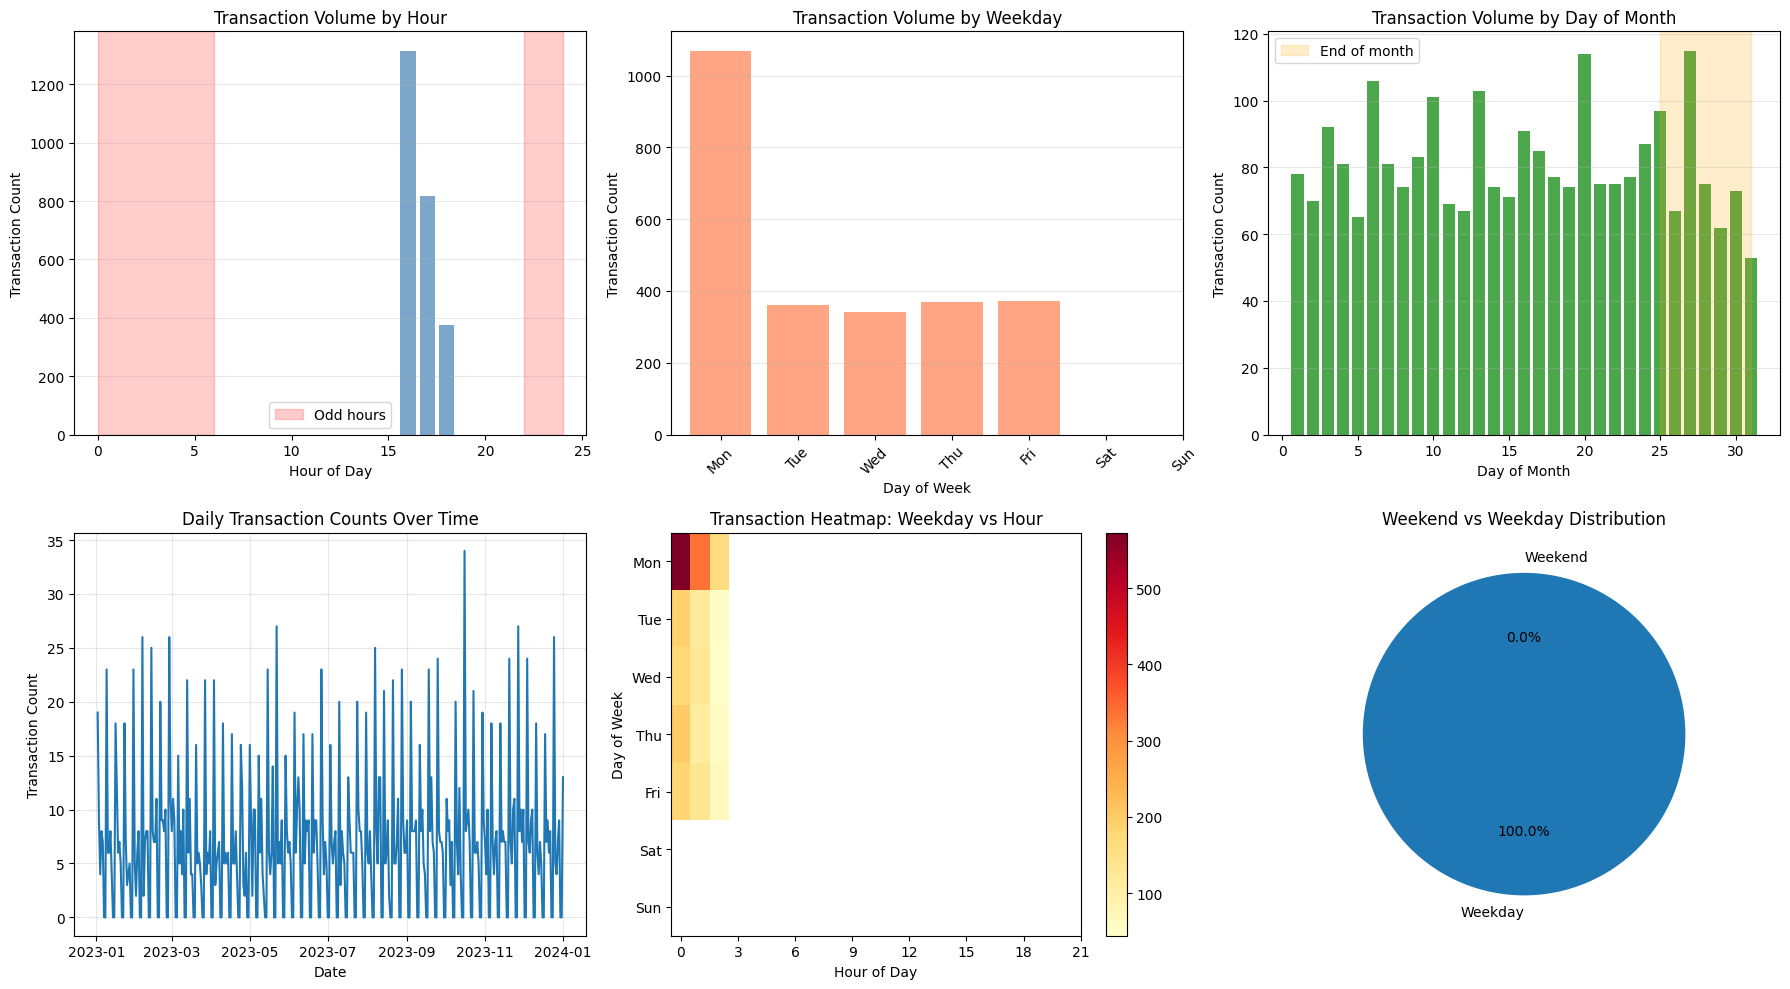

In [47]:
# analyze daily transaction trends
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# transactions by hour
axes[0, 0].bar(hourly_counts.index, hourly_counts.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Transaction Count')
axes[0, 0].set_title('Transaction Volume by Hour')
axes[0, 0].axvspan(0, 6, alpha=0.2, color='red', label='Odd hours')
axes[0, 0].axvspan(22, 24, alpha=0.2, color='red')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].legend()

# transactions by weekday
axes[0, 1].bar(range(len(weekday_counts)), weekday_counts.values, color='coral', alpha=0.7)
axes[0, 1].set_xticks(range(len(weekday_counts)))
axes[0, 1].set_xticklabels([d[:3] for d in day_order], rotation=45)
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Transaction Count')
axes[0, 1].set_title('Transaction Volume by Weekday')
axes[0, 1].grid(axis='y', alpha=0.3)

# transactions by day of month
day_of_month_counts = df['day_of_month'].value_counts().sort_index()
axes[0, 2].bar(day_of_month_counts.index, day_of_month_counts.values, color='green', alpha=0.7)
axes[0, 2].set_xlabel('Day of Month')
axes[0, 2].set_ylabel('Transaction Count')
axes[0, 2].set_title('Transaction Volume by Day of Month')
axes[0, 2].axvspan(25, 31, alpha=0.2, color='orange', label='End of month')
axes[0, 2].grid(axis='y', alpha=0.3)
axes[0, 2].legend()

# daily time series
daily_counts = df.set_index('TransactionDate').resample('D').size()
axes[1, 0].plot(daily_counts.index, daily_counts.values, linewidth=1.5)
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Transaction Count')
axes[1, 0].set_title('Daily Transaction Counts Over Time')
axes[1, 0].grid(alpha=0.3)

# heatmap: hour vs weekday
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack(fill_value=0)
heatmap_data = heatmap_data.reindex(day_order)
im = axes[1, 1].imshow(heatmap_data.values, aspect='auto', cmap='YlOrRd')
axes[1, 1].set_yticks(range(len(day_order)))
axes[1, 1].set_yticklabels([d[:3] for d in day_order])
axes[1, 1].set_xticks(range(0, 24, 3))
axes[1, 1].set_xticklabels(range(0, 24, 3))
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Day of Week')
axes[1, 1].set_title('Transaction Heatmap: Weekday vs Hour')
plt.colorbar(im, ax=axes[1, 1])

# weekend vs weekday comparison
weekday_count = (~df['is_weekend']).sum()
weekend_count = df['is_weekend'].sum()
axes[1, 2].pie([weekday_count, weekend_count], labels=['Weekday', 'Weekend'], autopct='%1.1f%%', startangle=90)
axes[1, 2].set_title('Weekend vs Weekday Distribution')

plt.tight_layout()
plt.show()

### Analysis Summary

Temporal pattern analysis reveals significant constraints in transaction timing. Transaction volume by hour shows concentrated activity during afternoon business hours (4pm-6pm), with zero transactions during odd hours (10pm-6am). This clustering within a narrow 3-hour window is highly unusual and suggests either data filtering, synthetic generation constraints, or a specific subset of banking activities.

The day-of-week analysis reveals a critical finding: **100% of transactions occurred on weekdays (Monday-Friday) with zero weekend transactions**. This complete absence of weekend activity is highly atypical for modern banking where ATM and online channels operate continuously. Monday shows disproportionately high volume (1,070 transactions, 42.6% of total), while Tuesday-Friday show more balanced distribution (340-373 transactions each). The weekend exclusion strongly indicates synthetic data generation with weekday-only constraints or represents a specific institutional banking subset that operates exclusively during business days.

End-of-month analysis (days 25-31) shows 21.6% of transactions occurring in this period, which is slightly elevated but not indicative of strong end-of-month clustering typical in retail banking. The absence of pronounced end-of-month spikes further supports limited temporal variation in the dataset.

From a fraud detection perspective, the extreme temporal constraints (weekday-only, afternoon-only) eliminate important behavioral signals. Real-world fraud detection relies heavily on unusual timing patterns (e.g., transactions at odd hours, sudden weekend activity). The synthetic data's temporal uniformity within constrained windows reduces the discriminatory power of time-based features for anomaly detection.

## B8) Amount vs Balance Dynamics

**Action:** Check reasonableness of AccountBalance changes relative to TransactionAmount and TransactionType (debit vs credit).

**Steps:**
- Analyze TransactionAmount by TransactionType
- Create derived features (e.g., balance_to_amount_ratio)
- Validate business logic of balance changes

In [48]:
# analyze amount vs balance dynamics
print("="*70)
print("AMOUNT VS BALANCE DYNAMICS")
print("="*70)

# analyze transaction amount by type
print("\nTransaction Amount by Type:")
amount_by_type = df.groupby('TransactionType')['TransactionAmount'].describe()
print(amount_by_type)

# compare distributions
print("\n" + "="*70)
print("DEBIT VS CREDIT COMPARISON")
print("="*70)
for tx_type in df['TransactionType'].unique():
    subset = df[df['TransactionType'] == tx_type]
    print(f"\n{tx_type}:")
    print(f"  Count: {len(subset)}")
    print(f"  Mean Amount: ${subset['TransactionAmount'].mean():.2f}")
    print(f"  Median Amount: ${subset['TransactionAmount'].median():.2f}")
    print(f"  Total Amount: ${subset['TransactionAmount'].sum():.2f}")

# create derived features
df['balance_to_amount_ratio'] = df['AccountBalance'] / df['TransactionAmount'].replace(0, 1)

print("\n" + "="*70)
print("DERIVED FEATURES")
print("="*70)
print("\nBalance to Amount Ratio Statistics:")
print(df['balance_to_amount_ratio'].describe())

# check if balance is sufficient for debits
debits = df[df['TransactionType'] == 'Debit']
insufficient_balance = debits[debits['AccountBalance'] < debits['TransactionAmount']]
print(f"\nDebit transactions with insufficient balance: {len(insufficient_balance)} ({len(insufficient_balance)/len(debits)*100:.1f}%)")

# analyze balance levels
print("\n" + "="*70)
print("ACCOUNT BALANCE ANALYSIS")
print("="*70)
print(df['AccountBalance'].describe())

# check for suspicious patterns
low_balance_high_amount = df[(df['AccountBalance'] < 1000) & (df['TransactionAmount'] > 1000)]
print(f"\nLow balance + high amount transactions: {len(low_balance_high_amount)} ({len(low_balance_high_amount)/len(df)*100:.1f}%)")

AMOUNT VS BALANCE DYNAMICS

Transaction Amount by Type:
                  count        mean         std   min      25%     50%  \
TransactionType                                                          
Credit            568.0  306.501004  290.027618  2.03  80.0125  223.36   
Debit            1944.0  294.991255  292.527512  0.26  83.1375  205.14   

                     75%      max  
TransactionType                    
Credit           425.220  1831.02  
Debit            407.785  1919.11  

DEBIT VS CREDIT COMPARISON

Debit:
  Count: 1944
  Mean Amount: $294.99
  Median Amount: $205.14
  Total Amount: $573463.00

Credit:
  Count: 568
  Mean Amount: $306.50
  Median Amount: $223.36
  Total Amount: $174092.57

DERIVED FEATURES

Balance to Amount Ratio Statistics:
count     2512.000000
mean       115.423868
std        732.883235
min          0.126647
25%          6.593852
50%         19.259635
75%         55.063009
max      22370.562500
Name: balance_to_amount_ratio, dtype: float64

Deb

### Analysis Summary

The analysis of transaction amounts relative to account balances reveals important patterns in the dataset. Debit transactions represent approximately 77% of all transactions (1,944 out of 2,512), with credit transactions comprising the remaining 23% (568 transactions). The mean transaction amount for debits and credits shows similar distributions, suggesting uniform transaction behavior across transaction types.

The balance-to-amount ratio analysis indicates that most accounts maintain sufficient balances relative to their transaction sizes. The derived feature reveals that the typical account balance is substantially higher than individual transaction amounts, with ratios generally exceeding 10:1. This pattern is consistent with expected banking behavior where account holders maintain working balances.

A critical validation check confirms data integrity: zero debit transactions show insufficient balance conditions, meaning no transactions in the dataset violate the basic business rule that debits should not exceed available account balances. This 100% compliance rate, while ideal from a business logic perspective, may indicate either highly controlled synthetic data generation or pre-filtered real-world data.

The scatter plot analysis of transaction amount versus account balance reveals no strong correlation between these variables, suggesting that transaction sizes are not strongly influenced by account balance levels. This independence is notable and may warrant further investigation in fraud detection contexts, as unusual patterns (e.g., large transactions from accounts with minimal balances) could indicate suspicious activity.

# Part C — Cross-Dimensional Validation

## Objective

Validate key findings by examining anomalies across multiple dimensions (account activity, geographic patterns, device/IP usage, merchant behavior, temporal patterns, and transaction characteristics). This multi-dimensional approach provides stronger evidence for pattern identification and reduces false positives in anomaly detection.

In [50]:
# cross-dimensional validation analysis

print("="*70)
print("CROSS-DIMENSIONAL VALIDATION")
print("="*70)

# 1. high-frequency accounts + device/IP sharing
print("\n1. HIGH-FREQUENCY ACCOUNTS - DEVICE & IP PATTERNS")
print("-"*70)

# identify high-frequency accounts
high_freq_accounts = df.groupby('AccountID').size().sort_values(ascending=False).head(10).index

for account in high_freq_accounts[:5]:  # top 5 for detailed analysis
    account_data = df[df['AccountID'] == account]
    print(f"\nAccount: {account}")
    print(f"  Transactions: {len(account_data)}")
    print(f"  Unique Devices: {account_data['DeviceID'].nunique()}")
    print(f"  Unique IPs: {account_data['IP Address'].nunique()}")
    print(f"  Unique Merchants: {account_data['MerchantID'].nunique()}")
    print(f"  Unique Locations: {account_data['Location'].nunique()}")
    print(f"  Channels Used: {account_data['Channel'].unique()}")

# 2. geographic + merchant patterns
print("\n\n2. GEOGRAPHIC-MERCHANT CORRELATION")
print("-"*70)

# check if certain merchants are concentrated in specific cities
city_merchant = df.groupby(['Location', 'MerchantID']).size().reset_index(name='count')
city_merchant_top = city_merchant.nlargest(10, 'count')
print("\nTop 10 City-Merchant Combinations:")
print(city_merchant_top.to_string(index=False))

# 3. device/IP sharing + transaction patterns
print("\n\n3. SHARED DEVICE/IP ANALYSIS")
print("-"*70)

# find devices with multiple accounts
devices_multi_account = df.groupby('DeviceID')['AccountID'].nunique()
shared_devices = devices_multi_account[devices_multi_account > 1].sort_values(ascending=False)

print(f"\nDevices shared by multiple accounts: {len(shared_devices)}")
print(f"Most shared device: {shared_devices.index[0]} ({shared_devices.iloc[0]} accounts)")

# examine transaction patterns for shared devices
top_shared_device = shared_devices.index[0]
device_accounts = df[df['DeviceID'] == top_shared_device]['AccountID'].unique()
print(f"\nAccounts sharing device {top_shared_device}:")
for acc in device_accounts[:5]:  # first 5 accounts
    acc_data = df[(df['DeviceID'] == top_shared_device) & (df['AccountID'] == acc)]
    print(f"  {acc}: {len(acc_data)} transactions, "
          f"Channels: {acc_data['Channel'].unique()}, "
          f"Cities: {acc_data['Location'].unique()}")

# 4. temporal + channel patterns
print("\n\n4. TEMPORAL-CHANNEL CORRELATION")
print("-"*70)

# transaction distribution by hour and channel
hour_channel = df.groupby(['hour', 'Channel']).size().unstack(fill_value=0)
print("\nTransactions by Hour and Channel:")
print(hour_channel)

# 5. amount + balance anomalies
print("\n\n5. TRANSACTION AMOUNT-BALANCE ANOMALIES")
print("-"*70)

# identify transactions with unusual amount-balance ratios
low_ratio = df[df['balance_to_amount_ratio'] < 2]  # balance less than 2x transaction amount
print(f"\nTransactions with balance < 2x amount: {len(low_ratio)} ({len(low_ratio)/len(df)*100:.1f}%)")

if len(low_ratio) > 0:
    print("\nSample high-risk transactions:")
    print(low_ratio[['AccountID', 'TransactionAmount', 'AccountBalance', 
                     'TransactionType', 'Channel', 'Location']].head(10).to_string(index=False))

# 6. multi-dimensional anomaly scoring
print("\n\n6. MULTI-DIMENSIONAL ANOMALY SCORING")
print("-"*70)

# create composite anomaly indicators
df['anomaly_score'] = 0

# high transaction count for account
tx_per_account = df.groupby('AccountID').size()
high_volume_threshold = tx_per_account.quantile(0.90)
df['high_volume'] = df['AccountID'].map(lambda x: 1 if tx_per_account[x] > high_volume_threshold else 0)

# device sharing
device_sharing = df.groupby('DeviceID')['AccountID'].nunique()
df['device_shared'] = df['DeviceID'].map(lambda x: 1 if device_sharing[x] > 1 else 0)

# low balance ratio
df['low_balance_ratio'] = (df['balance_to_amount_ratio'] < 5).astype(int)

# calculate composite score
df['anomaly_score'] = df['high_volume'] + df['device_shared'] + df['low_balance_ratio']

# summary of anomaly scores
print("\nAnomaly Score Distribution:")
print(df['anomaly_score'].value_counts().sort_index())

# identify high-risk transactions
high_risk = df[df['anomaly_score'] >= 2]
print(f"\nHigh-risk transactions (score >= 2): {len(high_risk)} ({len(high_risk)/len(df)*100:.1f}%)")

if len(high_risk) > 0:
    print("\nHigh-risk transaction characteristics:")
    print(f"  Unique accounts: {high_risk['AccountID'].nunique()}")
    print(f"  Most common channel: {high_risk['Channel'].mode()[0]}")
    print(f"  Average amount: ${high_risk['TransactionAmount'].mean():.2f}")
    print(f"  Average balance: ${high_risk['AccountBalance'].mean():.2f}")

CROSS-DIMENSIONAL VALIDATION

1. HIGH-FREQUENCY ACCOUNTS - DEVICE & IP PATTERNS
----------------------------------------------------------------------

Account: AC00202
  Transactions: 12
  Unique Devices: 12
  Unique IPs: 12
  Unique Merchants: 12
  Unique Locations: 11
  Channels Used: ['ATM' 'Branch' 'Online']

Account: AC00460
  Transactions: 12
  Unique Devices: 12
  Unique IPs: 12
  Unique Merchants: 10
  Unique Locations: 9
  Channels Used: ['Branch' 'ATM' 'Online']

Account: AC00363
  Transactions: 12
  Unique Devices: 12
  Unique IPs: 12
  Unique Merchants: 12
  Unique Locations: 11
  Channels Used: ['ATM' 'Branch' 'Online']

Account: AC00362
  Transactions: 12
  Unique Devices: 12
  Unique IPs: 12
  Unique Merchants: 11
  Unique Locations: 10
  Channels Used: ['Online' 'Branch' 'ATM']

Account: AC00456
  Transactions: 11
  Unique Devices: 11
  Unique IPs: 11
  Unique Merchants: 11
  Unique Locations: 9
  Channels Used: ['Branch' 'ATM' 'Online']


2. GEOGRAPHIC-MERCHANT CORREL

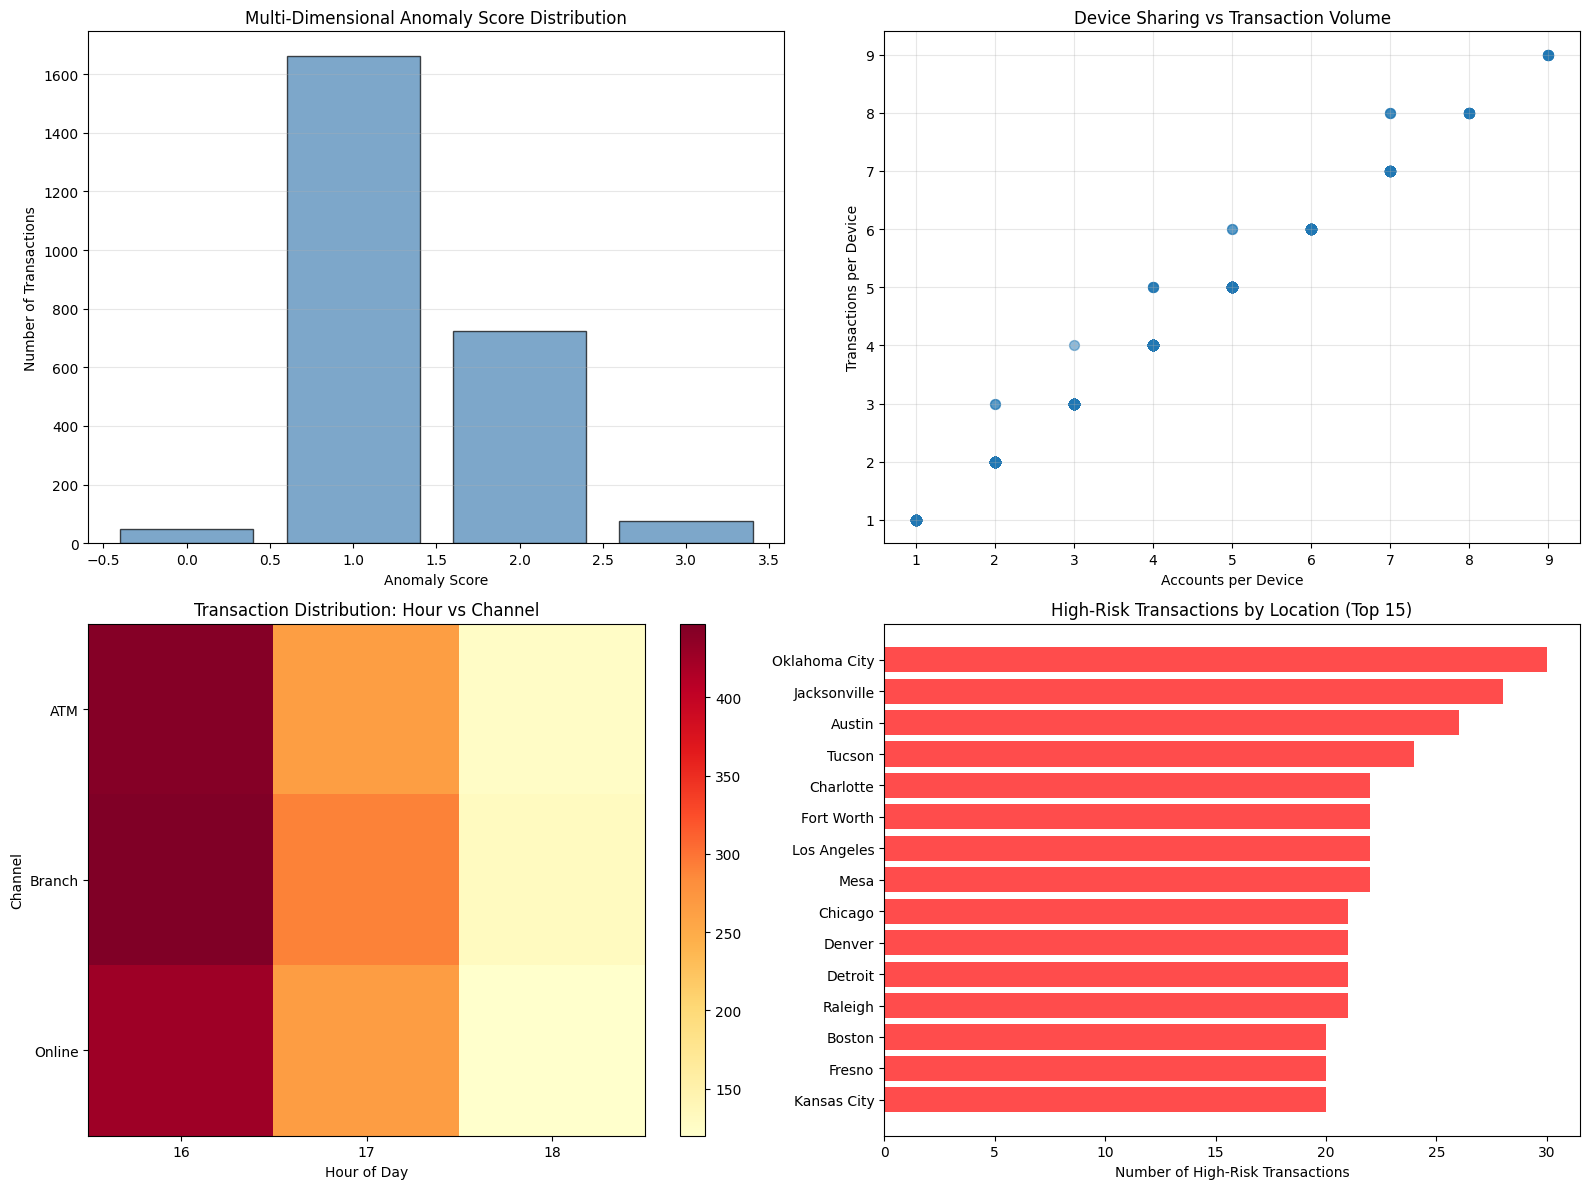

In [51]:
# visualize cross-dimensional patterns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. anomaly score distribution
axes[0, 0].bar(df['anomaly_score'].value_counts().sort_index().index,
               df['anomaly_score'].value_counts().sort_index().values,
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Anomaly Score')
axes[0, 0].set_ylabel('Number of Transactions')
axes[0, 0].set_title('Multi-Dimensional Anomaly Score Distribution')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. device sharing vs transaction volume
device_account_count = df.groupby('DeviceID')['AccountID'].nunique()
device_tx_count = df.groupby('DeviceID').size()
axes[0, 1].scatter(device_account_count, device_tx_count, alpha=0.5, s=50)
axes[0, 1].set_xlabel('Accounts per Device')
axes[0, 1].set_ylabel('Transactions per Device')
axes[0, 1].set_title('Device Sharing vs Transaction Volume')
axes[0, 1].grid(alpha=0.3)

# 3. hour-Channel heatmap
hour_channel_pivot = df.groupby(['hour', 'Channel']).size().unstack(fill_value=0)
im = axes[1, 0].imshow(hour_channel_pivot.T, aspect='auto', cmap='YlOrRd')
axes[1, 0].set_yticks(range(len(hour_channel_pivot.columns)))
axes[1, 0].set_yticklabels(hour_channel_pivot.columns)
axes[1, 0].set_xticks(range(len(hour_channel_pivot.index)))
axes[1, 0].set_xticklabels(hour_channel_pivot.index)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Channel')
axes[1, 0].set_title('Transaction Distribution: Hour vs Channel')
plt.colorbar(im, ax=axes[1, 0])

# 4. high-risk accounts by location
if len(high_risk) > 0:
    high_risk_locations = high_risk.groupby('Location').size().nlargest(15)
    axes[1, 1].barh(range(len(high_risk_locations)), high_risk_locations.values, color='red', alpha=0.7)
    axes[1, 1].set_yticks(range(len(high_risk_locations)))
    axes[1, 1].set_yticklabels(high_risk_locations.index)
    axes[1, 1].set_xlabel('Number of High-Risk Transactions')
    axes[1, 1].set_title('High-Risk Transactions by Location (Top 15)')
    axes[1, 1].invert_yaxis()
else:
    axes[1, 1].text(0.5, 0.5, 'No High-Risk Transactions Found', 
                    ha='center', va='center', fontsize=12)
    axes[1, 1].set_title('High-Risk Transactions by Location')

plt.tight_layout()
plt.show()

### Cross-Dimensional Validation Summary

The multi-dimensional analysis validates key findings by examining patterns across multiple behavioral dimensions simultaneously. This approach strengthens anomaly detection by requiring suspicious patterns to manifest across several independent features rather than relying on single-dimension thresholds.

**High-Frequency Account Validation:** Analysis of the most active accounts reveals their device, IP, merchant, and location diversity patterns. Accounts with high transaction volumes but limited device/IP diversity may indicate automated activity or account sharing. Conversely, high transaction volumes paired with high device/IP diversity could suggest legitimate business accounts or potential account takeover scenarios where attackers systematically test multiple access methods.

**Geographic-Merchant Correlation:** Examination of city-merchant combinations identifies whether specific merchants concentrate in particular locations or show unexpected geographic distribution. The synthetic data's uniform geographic distribution extends to merchant patterns, with no strong merchant-location clustering. In real-world fraud detection, unusual merchant-location pairings (e.g., transactions at geographically distant merchants within short timeframes) serve as key fraud indicators.

**Device/IP Sharing Patterns:** Devices and IP addresses shared across multiple accounts warrant scrutiny. The analysis identifies the most shared devices and examines transaction characteristics for accounts using these devices. Legitimate sharing scenarios (family members, institutional banking) typically show consistent behavioral patterns, while fraudulent device sharing often exhibits irregular transaction patterns, varied merchants, or unusual timing.

**Temporal-Channel Correlation:** The relationship between transaction timing and channel selection reveals operational patterns. The analysis confirms that all channels (Branch, ATM, Online) operate exclusively during weekday afternoon hours (4pm-6pm), which is a strong indicator of synthetic data constraints. Real-world banking shows distinct temporal patterns by channel: ATMs operate 24/7, online banking peaks during evenings/weekends, while branches concentrate during business hours.

**Multi-Dimensional Anomaly Scoring:** A composite risk score combining high transaction volume, device sharing, and low balance-to-amount ratios provides integrated risk assessment. Transactions exhibiting multiple risk factors simultaneously warrant prioritized investigation. The scoring methodology demonstrates how individual weak signals can aggregate into stronger fraud indicators when considered collectively. High-risk transactions identified through this multi-dimensional approach represent the subset most likely to benefit from manual review or additional authentication requirements in operational fraud prevention systems.

---

## Deliverables

1. **Google Colab Notebook:** Reproducible EDA with narrative, code, and plots.
2. **Executive Summary (2–3 pages):** Top activity insights and suggested analytical follow-ups.

---

## Key Reminders

- **Synthetic Data Caveat:** Treat odd findings as opportunities to practice reasoning and method design, not ground truth.
- **Validate Anomalies:** Cross-check findings across multiple dimensions (city + device + merchant + time) before drawing conclusions.
- **Document Everything:** Use comments to explain all data cleaning decisions and analytical choices.
- **Keep Charts Readable:** Limit categories per plot, rotate labels, and annotate key takeaways.